In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('customer_booking.csv', encoding = 'ISO-8859-1')

# High level overview of the dataset

In [3]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [5]:
df.shape

(50000, 14)

In [6]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

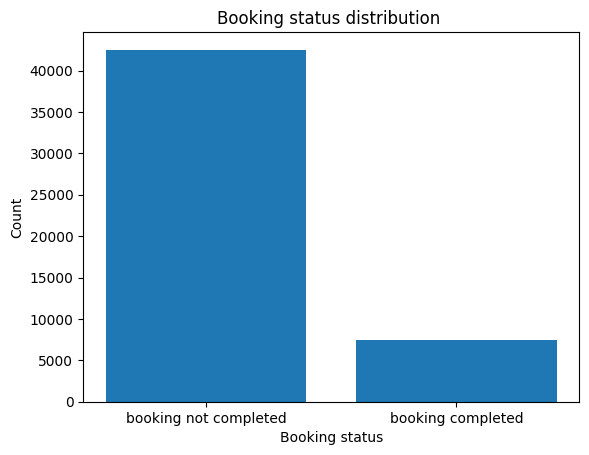

In [7]:
plt.bar(df['booking_complete'].unique(),df['booking_complete'].value_counts(), tick_label = ['booking not completed', 'booking completed'])
plt.ylabel('Count')
plt.xlabel('Booking status')
plt.title('Booking status distribution ')
plt.show()

# Data preprocessing

In [8]:
## Since there is a huge imbalance in the target variable, undersampling can be utilised 
from sklearn.utils import resample
booking_not_complete = df[df['booking_complete'] == 0]
booking_complete = df[df['booking_complete'] == 1]
booking_not_complete = resample(booking_not_complete, replace = False,n_samples = len(booking_complete), random_state = 42)

In [9]:
balanced_df = pd.concat([booking_not_complete,booking_complete])
balanced_df = balanced_df.sample(frac = 1, random_state = 42)

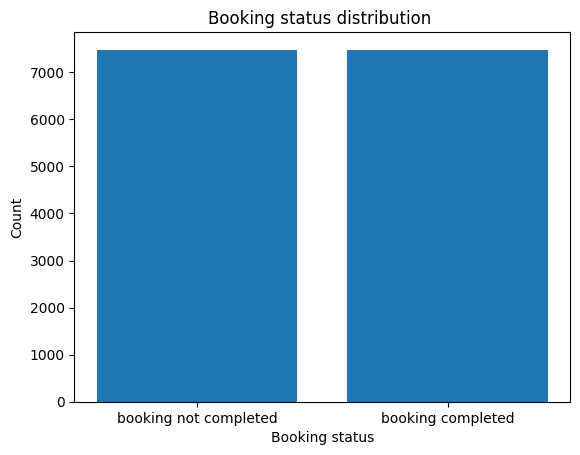

In [10]:
plt.bar(balanced_df['booking_complete'].unique(),balanced_df['booking_complete'].value_counts(), tick_label = ['booking not completed', 'booking completed'])
plt.ylabel('Count')
plt.xlabel('Booking status')
plt.title('Booking status distribution ')
plt.show()

In [11]:
X = balanced_df.drop(columns = ['booking_complete'])
y = balanced_df['booking_complete']

In [12]:
for col in X.columns:
    if X[col].dtypes == 'object':
        X[col], _ = X[col].factorize()

In [13]:
X.dtypes

num_passengers             int64
sales_channel              int64
trip_type                  int64
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                      int64
booking_origin             int64
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
dtype: object

In [14]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X,y)
mi = pd.Series(mi, name ='MI Scores', index = X.columns)
mi = mi.sort_values(ascending= False)
mi

route                    0.102970
booking_origin           0.082329
flight_duration          0.031794
length_of_stay           0.016618
purchase_lead            0.006798
flight_day               0.005858
trip_type                0.002949
num_passengers           0.000000
sales_channel            0.000000
flight_hour              0.000000
wants_extra_baggage      0.000000
wants_preferred_seat     0.000000
wants_in_flight_meals    0.000000
Name: MI Scores, dtype: float64

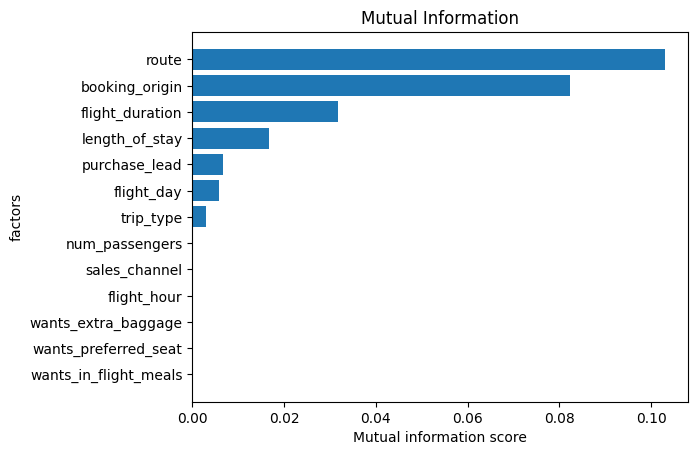

In [16]:
plt.barh(mi.index,mi.values)
plt.gca().invert_yaxis()
plt.xlabel('Mutual information score')
plt.ylabel('factors')
plt.title('Mutual Information')
plt.show()

In [17]:
X = pd.get_dummies(X, columns = ['sales_channel', 'trip_type','flight_day','route','booking_origin'])
X = X.replace(False,0)
X = X.replace(True, 1)

# Training the model

In [18]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range =(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
clf = RandomForestClassifier()
clf.fit(X_train,y_train)

RandomForestClassifier()

In [21]:
y_pred = clf.predict(X_test)

In [22]:
print(pd.DataFrame(confusion_matrix(y_test,y_pred), index = ['booking_completed','booking_not_completed'], columns = ['booking_completed','booking_not_completed']))
print('\n')
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'AUC score : {roc_auc_score(y_test,y_pred)}')

                       booking_completed  booking_not_completed
booking_completed                   1474                    730
booking_not_completed                563                   1720


Accuracy Score: 0.7118341876532204
AUC score : 0.7110893425961479
